In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import lzma
import numpy as np
import matplotlib.pyplot as plt
import random
import json
import pickle
from torch.utils.data import TensorDataset, DataLoader
import itertools
import os

In [2]:
from utils.model import deviceof, set_lr_on_step
from utils.env import State, Action, Observation, Transition, state_batch_to_tensor, action_batch_to_tensor, obs_batch_to_tensor
from utils.idm_model_def import InverseDynamicsModel, idm_train_direct_batch
from utils.loader import getFiles
from utils.waymo_loader import extract_scenarios_file

2023-09-17 16:00:06.615574: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 16:00:07.851851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# CHANGE ME: Set this to the path to the Waymo Open Dataset root directory
WAYMO_DATA_PATH = "~/data/waymo"

In [37]:
# load data
with lzma.open("./data/transition_data_2500k.pkl.xz", "rb") as f:
    transition_data: list[Transition] = pickle.load(f)

# 95:15 train-validation split
transition_train_data = transition_data[:int(len(transition_data)*0.95)]
transition_validation_data = transition_data[int(len(transition_data)*0.95):]

print("train data size:", len(transition_train_data))
print("validation data size:", len(transition_validation_data))

train data size: 2375000
validation data size: 125000


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
obs_train_tensor = obs_batch_to_tensor([Observation(t.state, t.next_state) for t in transition_train_data], device)
action_train_tensor = action_batch_to_tensor([t.action for t in transition_train_data], device)

obs_validation_tensor = obs_batch_to_tensor([Observation(t.state, t.next_state) for t in transition_validation_data], device)
action_validation_tensor = action_batch_to_tensor([t.action for t in transition_validation_data], device)

In [12]:
idm_train_dataset = TensorDataset(
    obs_train_tensor,
    action_train_tensor,
)
idm_train_loader = DataLoader(idm_train_dataset, batch_size=8192)
idm_train_iter = itertools.cycle(iter(idm_train_loader))

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.AdamW(idm.parameters(), lr=0.0)

idm_step = 0
idm_losses = []

In [46]:
LR_SCHEDULE = {
    0: 1e-3,
    20_000: 5e-4,
    40_000: 2e-4,
    60_000: 1e-4,
    80_000: 5e-5,
}
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 100_000
idm.train()
while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    set_lr_on_step(idm_step, idm_optimizer, LR_SCHEDULE)
    obs_tensor, a_tensor = next(idm_train_iter) 
    loss = idm_train_direct_batch(
        idm,
        idm_optimizer,
        obs_tensor,
        a_tensor,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 1000 == 0:
        # print average loss over last 100 steps
        loss = np.mean(idm_losses[-1000:])
        print(f"Step: {idm_step}, Loss: {loss:.6f}")

Step: 57000, Loss: 0.011904
Step: 58000, Loss: 0.012159
Step: 59000, Loss: 0.012056
Step: 60000, Loss: 0.011947
Set learning rate to 0.0001 on step 60000


KeyboardInterrupt: 

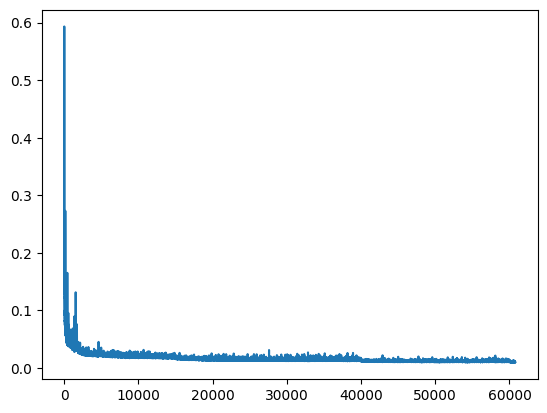

In [47]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

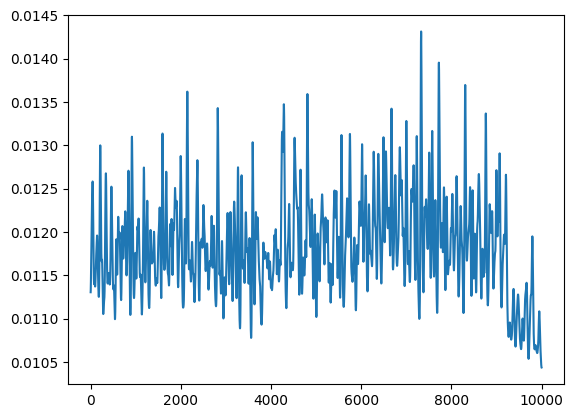

In [48]:
from scipy.ndimage import gaussian_filter1d

# plot the average reward per episode
idm_losses_averaged = gaussian_filter1d(idm_losses[-10000:], sigma=10)
plt.plot(idm_losses_averaged)

In [52]:
# save IDM
if not os.path.exists('./data/idm.pth'):
    torch.save(idm.state_dict(), './data/idm.pth')

In [23]:
# load IDM
if 'idm' not in locals():
    idm = InverseDynamicsModel().to(device)
    idm.load_state_dict(torch.load('./data/idm.pth'))

In [49]:
idm.eval()

obs_tensor = obs_train_tensor[:100000]
a_tensor = action_train_tensor[:100000]

a_pred_tensor = idm(obs_tensor)

loss = (a_tensor - a_pred_tensor)**2
loss_steer = loss[:, 0].cpu().detach().numpy()
loss_throttle = loss[:, 1].cpu().detach().numpy()

print("training loss", loss.mean().item())

training loss 0.011498316191136837


In [50]:
idm.eval()

obs_tensor = obs_validation_tensor
a_tensor = action_validation_tensor

a_pred_tensor = idm(obs_tensor)

loss = (a_tensor - a_pred_tensor)**2
loss_steer = loss[:, 0].cpu().detach().numpy()
loss_throttle = loss[:, 1].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 0.012028470635414124


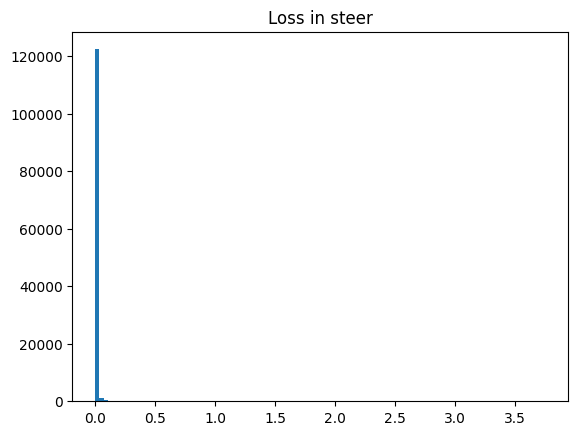

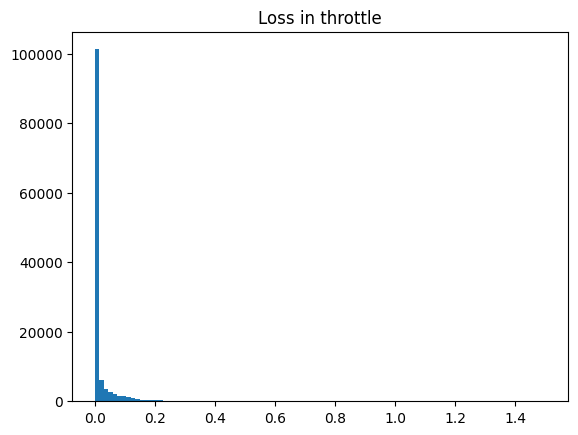

In [51]:
plt.hist(loss_steer, bins=100)
plt.title('Loss in steer')
plt.show()
plt.hist(loss_throttle, bins=100)
plt.title('Loss in throttle')
plt.show()

In [13]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return Action(steering.item(), throttle.item())

In [14]:
scenarios = extract_scenarios_file(getFiles(WAYMO_DATA_PATH)[0])

2023-09-16 21:26:25.732171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-16 21:26:25.748789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-16 21:26:25.748991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf